# TODO
- handle Nan values
- add races columns to df based on year
- figure out how to include Hispanic people (they are not given in the Kees's dataset)
- add more info about candidates

In [284]:
# ledb_candid #Unique identifier for the candidate in the dataset.
# fips #Federal Information Processing Standards code for the geographic area of the election

# district #The district or region within the geographic area (e.g., "Los Angeles").
# votes # The number of votes received by the candidate in the election
# vote_share #  The percentage of the total vote share received by the candidate  - we will have to softmax this
# n_winners # The number of winners for this election - check this
# winner # Indicates whether the candidate won the election 
# incumbent # indicates whether the candidate was an incumbent
# contributor.cfscore # CFscore, a measure of the candidate's ideological position based on campaign finance data (negative values = more liberal, positive values = more conservative)
# prob_democrat # The probability that the candidate is a Democrat
# pid_est # The estimated party ID of the candidate (D for Democrat, R for Republican, etc.).
# prob_male # The probability that the candidate is male
# gender_est # The estimated gender of the candidate (e.g., "M" for male, "F" for female).
# prob_black # Probability that the candidate is Black 
# prob_white # Probability that the candidate is White
# prob_hispanic # Probability that the candidate is Hispanic
# prob_asian # Probability that the candidate is Asian
# prob_other # Probability that the candidate is other
# race_est # The estimated race

# year # The year of the election
# contest # Unique identifier for the specific election contest

In [285]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from scipy.optimize import curve_fit

warnings.filterwarnings("ignore")

In [286]:
# Load the data
df = pd.read_csv('ledb_candidatelevel.csv')
df_mayor = df[df['office_consolidated'] == 'Mayor']

In [287]:
# Drop columns that are not useful
columns_shared_across_candidates = ['state_abb', 'geo_name', 'year', 'contest', 'fips']
columns_individual_candidate = ['vote_share', 'incumbent', 'contributor.cfscore', 'prob_democrat', 'gender_est', 'race_est', 'pid_est']
columns_to_drop = df_mayor.columns.difference(columns_shared_across_candidates + columns_individual_candidate)

df_mayor = df_mayor.drop(columns=columns_to_drop)

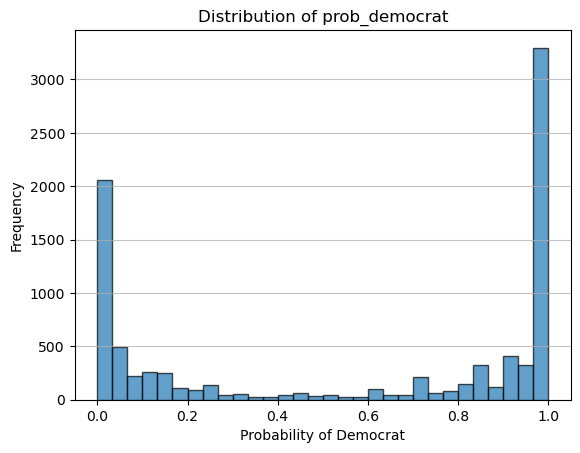

In [288]:
# Display distribution of "prob_democrat"
df_mayor['prob_democrat'].plot(kind='hist', bins=30, edgecolor='black', alpha=0.7)

plt.title('Distribution of prob_democrat')
plt.xlabel('Probability of Democrat')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

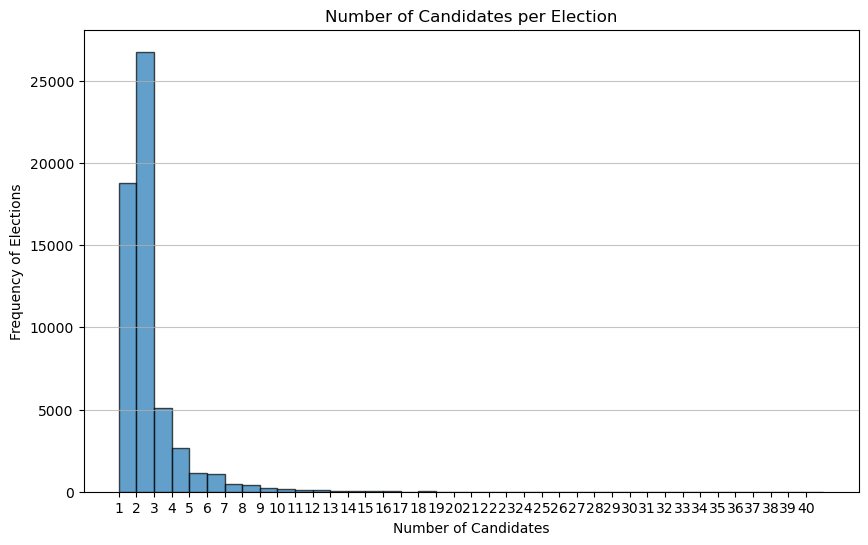

In [289]:
# Display distribution of "contributor.cfscore"
candidates_per_contest = df.groupby('contest').size()

plt.figure(figsize=(10, 6))
plt.hist(candidates_per_contest, bins=range(1, candidates_per_contest.max() + 2), edgecolor='black', alpha=0.7)
plt.title('Number of Candidates per Election')
plt.xlabel('Number of Candidates')
plt.ylabel('Frequency of Elections')
plt.xticks(range(1, candidates_per_contest.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

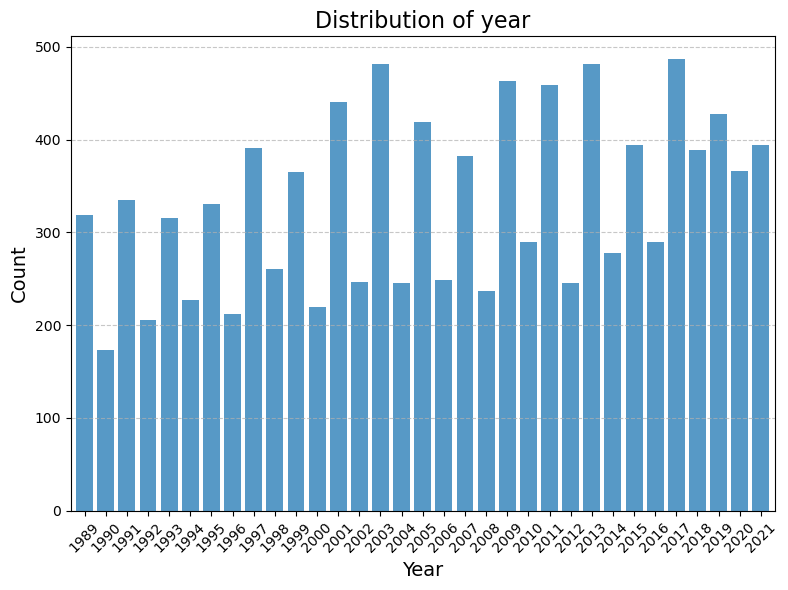

In [290]:
# Display distribution of "year"
year_counts = df_mayor["year"].value_counts().sort_index()

plt.figure(figsize=(8, 6))
year_counts.plot(kind='bar', width=0.8, alpha=0.75)
plt.title("Distribution of year", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [291]:
def process_contests(df, columns_shared_across_candidates, columns_individual):
    """
    Processes a DataFrame of election data to combine the top two candidates
    from contests where there are at least two candidates, ensuring the Republican
    candidate comes first and the Democrat second.

    Returns:
        pd.DataFrame: Processed DataFrame with combined candidate data for each contest.
    """
    def reorder_candidates(group):
        """
        Ensures the Republican candidate appears as the first row in the group.
        """
        if group.iloc[0]['pid_est'] != 'R':
            group.iloc[[0, 1]] = group.iloc[[1, 0]].copy()
        return group

    def combine_candidates(group):
        """
        Combines the top two candidates into a single row for a contest.
        """
        combined = {col: group.iloc[0][col] for col in columns_shared_across_candidates}
        for i, suffix in enumerate(['_rep', '_dem']):
            for col in columns_individual:
                combined[f"{col}{suffix}"] = group.iloc[i][col]
        return pd.Series(combined)

    # Filter contests with at least two candidates
    df = df.groupby('contest').filter(lambda x: len(x) >= 2)

    # Sort candidates by vote share within each contest
    df = df.sort_values(by=['contest', 'vote_share'], ascending=[True, False])

    # Select top two candidates per contest
    df = df.groupby('contest').head(2)

    # Keep contests where the top two candidates are from different parties
    df = df.groupby('contest').filter(lambda x: x['pid_est'].nunique() == 2)

    # Ensure Republican candidate is listed first
    df = df.groupby('contest', group_keys=False).apply(reorder_candidates).reset_index(drop=True)

    # Combine candidates into a single row per contest
    df = df.groupby('contest', group_keys=False).apply(combine_candidates).reset_index(drop=True)

    return df


In [292]:
# Process the mayor data
df_mayor = process_contests(df_mayor, columns_shared_across_candidates, columns_individual_candidate)

# Load and preprocess the city constituency data
df_city_consituency = pd.read_csv('cities_constituency_data.csv')
columns_city_consituency_to_drop = ['geo_name', 'index', 'state', 'mass_ideology_2020_se', 'geo_type']
df_city_consituency = df_city_consituency.drop(columns=columns_city_consituency_to_drop)
df_city_consituency['fips'] = df_city_consituency['fips'].astype(int)

# Ensure FIPS codes are integers in both DataFrames
df_mayor['fips'] = df_mayor['fips'].astype(int)

# Merge the DataFrames on FIPS
df_mayor = pd.merge(df_mayor, df_city_consituency, on='fips', how='left')

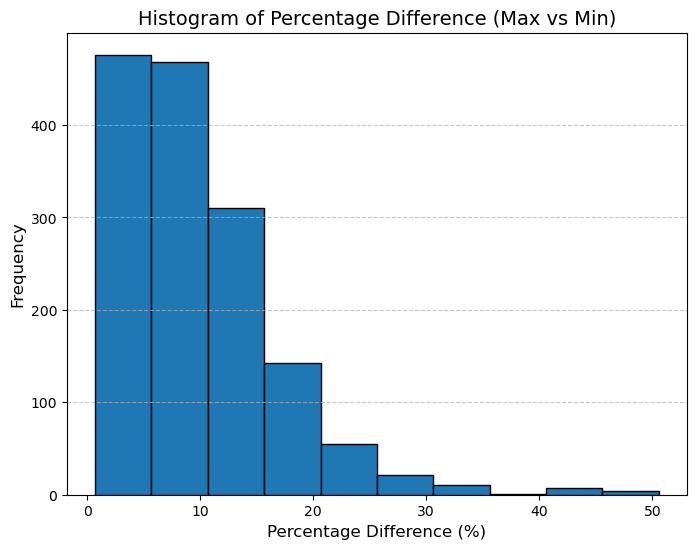

In [293]:
# Calculate max-min difference and percentage difference without modifying the original data
max_min_diff = df_mayor[["pres_pctD_20", "pres_pctD_16", "pres_pctD_08"]].max(axis=1) - df_mayor[["pres_pctD_20", "pres_pctD_16", "pres_pctD_08"]].min(axis=1)
percent_diff = (max_min_diff / df_mayor[["pres_pctD_20", "pres_pctD_16", "pres_pctD_08"]].mean(axis=1)) * 100

# Plot histogram of percentage differences
plt.figure(figsize=(8, 6))
plt.hist(percent_diff, bins=10, edgecolor='black')
plt.title("Histogram of Percentage Difference (Max vs Min)", fontsize=14)
plt.xlabel("Percentage Difference (%)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [294]:
def predict_exponential_for_closest_past_year(y_observed, year):
    """
    Predict the value for the closest past year divisible by 4.

    Returns:
    predicted_value (float): Predicted value for the closest past year divisible by 4.
    closest_year (int): The closest past year divisible by 4.
    """
    x_observed = np.array([2008, 2016, 2020])
    x_observed_normalized = x_observed - np.mean(x_observed)

    # Define the exponential model
    def exponential_model(x, a, b):
        return a * np.exp(b * x)

    # Fit the model
    params, _ = curve_fit(
        exponential_model,
        x_observed_normalized,
        y_observed,
    )

    a, b = params

    # Find the nearest past year divisible by 4
    closest_year = year - (year % 4)

    # Predict value for the closest year
    if closest_year in x_observed:
        predicted_value = y_observed[np.where(x_observed == closest_year)[0][0]]
    else:
        closest_year_normalized = closest_year - np.mean(x_observed)
        predicted_value = exponential_model(closest_year_normalized, a, b)

    return predicted_value, closest_year, params


Predicted value for the closest past year divisible by 4 (2012): 0.3391554142532974


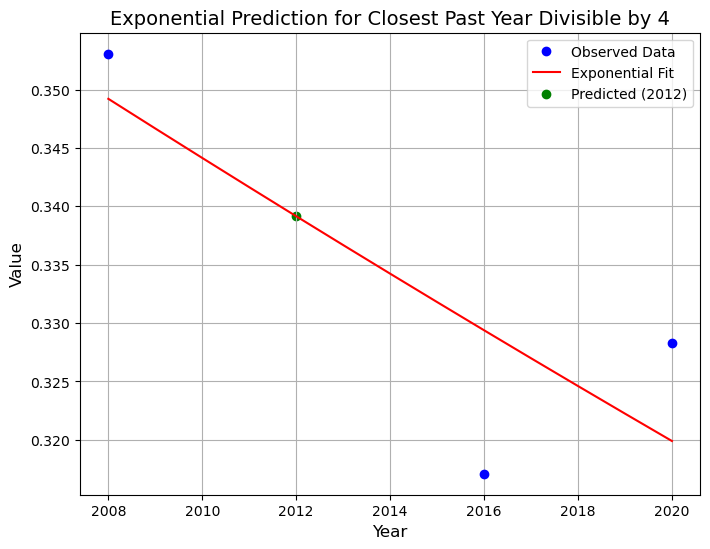

In [295]:
# Example usage
x_observed = np.array([2008, 2016, 2020])  # Observed years
y_observed = np.array([0.353084125509256, 0.317087778401647, 0.328329515706806])  # Observed values
year = 2013  # Target year

predicted_value, closest_year, params = predict_exponential_for_closest_past_year(y_observed, year)
if predicted_value is not None:
    print(f"Predicted value for the closest past year divisible by 4 ({closest_year}): {predicted_value}")

def exponential_model(x, a, b):
    return a * np.exp(b * x)

# Plot the results
x_all = np.arange(min(x_observed), max(x_observed) + 1)
x_all_normalized = x_all - np.mean(x_observed)
a, b = params
y_all = exponential_model(x_all_normalized, a, b)

plt.figure(figsize=(8, 6))
plt.plot(x_observed, y_observed, 'bo', label='Observed Data')
plt.plot(x_all, y_all, 'r-', label='Exponential Fit')
plt.scatter([closest_year], [predicted_value], color='green', label=f'Predicted ({closest_year})')
plt.title("Exponential Prediction for Closest Past Year Divisible by 4", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

In [296]:
def compute_pres_pctD(row):
    # Extract observed percentage values for Democratic votes in past elections (2008, 2016, 2020) from the row
    y_observed = row[["pres_pctD_08", "pres_pctD_16", "pres_pctD_20"]].values.astype(float)

    # Predict the Democratic vote percentage for the specified year in the row
    predicted_value, *_ = predict_exponential_for_closest_past_year(y_observed, row["year"])
    return predicted_value

# Drop rows where 'pres_pctD_08' (Democratic vote percentage for 2008) is missing
df_mayor = df_mayor.dropna(subset=['pres_pctD_08'])

# This calculates the predicted Democratic vote percentage and stores it in a new column 'pres_pctD'
df_mayor["pres_pctD"] = df_mayor.apply(compute_pres_pctD, axis=1)

# These columns are no longer needed since their values have been used for prediction
df_mayor = df_mayor.drop(columns=["pres_pctD_20", "pres_pctD_16", "pres_pctD_08"])

# Assign 'white' to rows where 'race_est_dem' is 'caucasian'; otherwise, assign 'non_white'
df_mayor['race_est_dem'] = np.where(df_mayor['race_est_dem'] == 'caucasian', 'white', 'non_white')


In [297]:
display(df_mayor)

,state_abb,geo_name,year,contest,fips,vote_share_rep,incumbent_rep,contributor.cfscore_rep,prob_democrat_rep,gender_est_rep,...,race_est_dem,pid_est_dem,population_2020,mass_ideology_2020,percent_women,percent_white,percent_black,percent_hispanic,percent_asian_american,pres_pctD
0,DE,wilmington,1992,1077580_1992_11_wilmington_DE_Mayor_mayor_1,1077580,0.09,NaN,NaN,0.0,F,...,non_white,D,70898.0,-0.302760,0.525989,0.291716,0.582597,0.101948,0.013929,0.891903
1,DE,wilmington,1996,1077580_1996_11_wilmington_DE_Mayor_mayor_1,1077580,0.39,0.0,NaN,0.0,M,...,non_white,D,70898.0,-0.302760,0.525989,0.291716,0.582597,0.101948,0.013929,0.890173
2,DE,wilmington,2004,1077580_2004_11_wilmington_DE_Mayor_mayor_1,1077580,0.27,0.0,NaN,0.0,M,...,white,D,70898.0,-0.302760,0.525989,0.291716,0.582597,0.101948,0.013929,0.886721
3,DE,wilmington,2016,1077580_2016_11_wilmington_DE_Mayor_mayor_1,1077580,0.11,0.0,1.01,0.0,M,...,white,D,70898.0,-0.302760,0.525989,0.291716,0.582597,0.101948,0.013929,0.878289
4,DC,washington,1990,1150000_1990_11_washington_DC_Mayor_mayor_1,1150000,0.11,NaN,NaN,0.0,M,...,non_white,D,689545.0,-0.469090,0.525549,0.365785,0.463143,0.109994,0.048946,0.914489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1505,CT,waterbury,2013,980000_2013_11_waterbury_CT_Mayor_mayor_1,980000,0.20,0.0,NaN,0.0,M,...,white,D,114403.0,-0.194367,0.520623,0.378071,0.217038,0.374441,0.027559,0.624277
1506,CT,waterbury,2019,980000_2019_11_waterbury_CT_Mayor_mayor_1,980000,0.20,0.0,0.89,0.0,NaN,...,white,D,114403.0,-0.194367,0.520623,0.378071,0.217038,0.374441,0.027559,0.607515
1507,CT,west haven,2017,982800_2017_11_west haven_CT_Mayor_mayor_1,982800,0.40,0.0,1.13,0.0,M,...,white,D,55584.0,-0.309614,0.499918,0.503059,0.205960,0.231835,0.045140,0.649958
1508,CT,west haven,2019,982800_2019_11_west haven_CT_Mayor_mayor_1,982800,0.40,0.0,1.06,0.0,F,...,white,D,55584.0,-0.309614,0.499918,0.503059,0.205960,0.231835,0.045140,0.649958


In [298]:
df_mayor.isna().sum()

state_abb                    0
geo_name                     0
year                         0
contest                      0
fips                         0
vote_share_rep               0
incumbent_rep              226
contributor.cfscore_rep    582
prob_democrat_rep            0
gender_est_rep              48
race_est_rep                12
pid_est_rep                  0
vote_share_dem               0
incumbent_dem              226
contributor.cfscore_dem    525
prob_democrat_dem            0
gender_est_dem              47
race_est_dem                 0
pid_est_dem                  0
population_2020              0
mass_ideology_2020           0
percent_women                0
percent_white                0
percent_black                0
percent_hispanic             0
percent_asian_american       0
pres_pctD                    0
dtype: int64